In [ ]:
import jpype

jpype.startJVM(jpype.getDefaultJVMPath())

In [34]:
import pickle as pkl
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator, LogLocator
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import chirp as chirpsig
from scipy.signal import find_peaks as find_peaks
from scipy.signal import get_window


In [35]:
RIPPLE = 50 #Hz
def generate_transfer_function_plot(dir):

    files = os.listdir(dir)

    scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')]
    scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')]
    cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')]
    cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')]
    int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')]
    int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')]
    qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')]
    blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')]

    scope0_files.sort()
    scope1_files.sort()
    cal1000_files.sort()
    cal1100_files.sort()
    int1000_files.sort()
    int1001_files.sort()
    qmeter_files.sort()
    blm_files.sort()

    initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

    scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files[1:]]
    scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files[1:]]
    cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files[1:]]
    cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files[1:]]
    int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files[1:]]
    int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files[1:]]
    qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files[1:]]
    blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files[1:]]

    scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
    scope_sample_rate = 1/scope_time_per_sample

    fig, ax = plt.subplots(len(int1000), 5, figsize=(14, 10), sharex='col', tight_layout=True)

    tf_df = pd.DataFrame(columns=['Frequency', 'Damper', 'Spill'])


    for i, (param, int1k, scp) in enumerate(list(zip(initial['param_space'], int1000, scope0))):
        
        fifofreq = int1k['EaConfig']['fifoFreq']

        int_data = int1k['countArray']
        int_time_reconstructed = np.arange(0, len(int_data) * 1/fifofreq, 1/fifofreq)
        ax[i, 0].plot(int_time_reconstructed, int_data, 'k')
        ax[i, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        ax[i, 0].set_xlim(0.15, 0.4)

        int_yf = rfft(int_data)
        int_xf = rfftfreq(len(int_data), 1/fifofreq)
        ax[i, 1].plot(int_xf, np.abs(int_yf), 'b')
        ax[i, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        ax[i, 1].set_yscale('log')

        scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
        scp_timeRebase = scp_time - scp_time[0]
        scp_data = np.array(scp['data']['value'])
        ax[i, 2].plot(scp_timeRebase, scp_data, 'k')
        ax[i, 2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        ax[i, 2].set_xlim(0, 1e-2)
        ax[i, 2].set_xticks([0, 0.005, 0.01])

        scp_window = get_window
        scp_yf = rfft(scp_data)
        scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)
        ax[i, 3].plot(scp_xf, np.abs(scp_yf), 'b')
        ax[i, 3].set_yscale('log')
        ax[i, 3].set_xlim(-50, 1050)

        ax[i, 4].loglog(int_xf, np.abs(int_yf) / np.abs(scp_yf)[:len(int_xf)], 'b')

        if initial['knob'] == 'interval':
            ax[i, 0].set_ylabel(f"{RIPPLE} Hz")
            ax[i, 1].axvline(RIPPLE, color='r', linestyle=':', alpha=0.5)
            ax[i, 3].axvline(RIPPLE, color='r', linestyle=':', alpha=0.5)

        driving_freq = RIPPLE
        try:
            spill_sig_at_driving_freq = np.abs(int_yf[np.round_(int_xf, 0) == driving_freq][0])
        except IndexError:
            spill_sig_at_driving_freq = np.abs((int_yf[np.round_(int_xf, 0) == driving_freq+1][0] + int_yf[np.round_(int_xf, 0) == driving_freq-1][0])/2)
        try:
            damper_sig_at_driving_freq = np.abs(scp_yf[np.round_(scp_xf, 0) == driving_freq][0])
        except IndexError:
            damper_sig_at_driving_freq = np.abs((scp_yf[np.round_(scp_xf, 0) == driving_freq+1][0] + scp_yf[np.round_(scp_xf, 0) == driving_freq-1][0])/2)

        spill_dc_component = np.abs(int_yf[0])
        damper_dc_component = np.abs(scp_yf[0])
        tf_df = pd.concat([tf_df, pd.DataFrame.from_records([{'Frequency': driving_freq, 'Damper': damper_sig_at_driving_freq/damper_dc_component, 'Spill': spill_sig_at_driving_freq/spill_dc_component}])], ignore_index=True)


    ax[0, 0].set_title('Spill monitor signal')
    ax[0, 1].set_title('Spill signal FFT')

    ax[0, 2].set_title('Damper plates signal')
    ax[0, 3].set_title('Damper signal FFT')

    ax[0, 4].set_title('Transfer Function')

    ax[i, 0].set_xlabel("Seconds")
    ax[i, 1].set_xlabel("Hz")

    ax[i, 2].set_xlabel("Seconds")
    ax[i, 3].set_xlabel("Hz")

    ax[i, 4].set_xlabel("Hz")

    gain = initial['qmeter_settings']['ex_h_amplitude'][1]
    plt.suptitle(f"Interval Scan from 1 to 9 ms at {gain} Gain")

    plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

    ffig, aax = plt.subplots(2, 2, figsize=(8, 3), tight_layout=True, sharex="col")

    for i, (param, int1k, scp) in enumerate(list(zip(initial['param_space'], int1000, scope0))):
        if i == 2:
            fifofreq = int1k['EaConfig']['fifoFreq']
            int_data = int1k['countArray']

            int_time_reconstructed = np.arange(0, len(int_data) * 1/fifofreq, 1/fifofreq)
            aax[0, 0].plot(int_time_reconstructed, int_data, 'k')
            aax[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            aax[0, 0].set_ylabel("Counts")

            int_yf = rfft(int_data)
            int_xf = rfftfreq(len(int_data), 1/fifofreq)
            aax[0, 1].plot(int_xf, np.abs(int_yf), 'k')
            aax[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            aax[0, 1].set_yscale('log')
            aax[0, 1].set_ylabel("Spill signal\n(arb.)")
            aax[0, 1].set_title("Measurement data")

            scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
            scp_timeRebase = scp_time - scp_time[0]
            scp_data = np.array(scp['data']['value'])
            aax[1, 0].plot(scp_timeRebase, scp_data, 'k')
            aax[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            aax[1, 0].set_xlim(0, 1e-2)
            aax[1, 0].set_xticks([0, 0.005, 0.01])
            aax[1, 0].set_ylabel("Volts")

            scp_window = get_window
            scp_yf = rfft(scp_data)
            scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)
            aax[1, 1].plot(scp_xf, np.abs(scp_yf), 'k')
            aax[1, 1].set_yscale('log')
            aax[1, 1].set_xlim(0, 550)
            aax[1, 1].set_ylabel("TFB signal\n(arb.)")

            aax[0, 1].axvline(1/(param * 1e-3), color='r', linestyle='-', alpha=0.9, zorder=-1)
            aax[1, 1].axvline(1/(param * 1e-3), color='r', linestyle='-', alpha=0.9, zorder=-1)

            aax[1, 1].set_xlabel("Hz")

            
        else:
            continue



    return tf_df

# 0.15 Gain

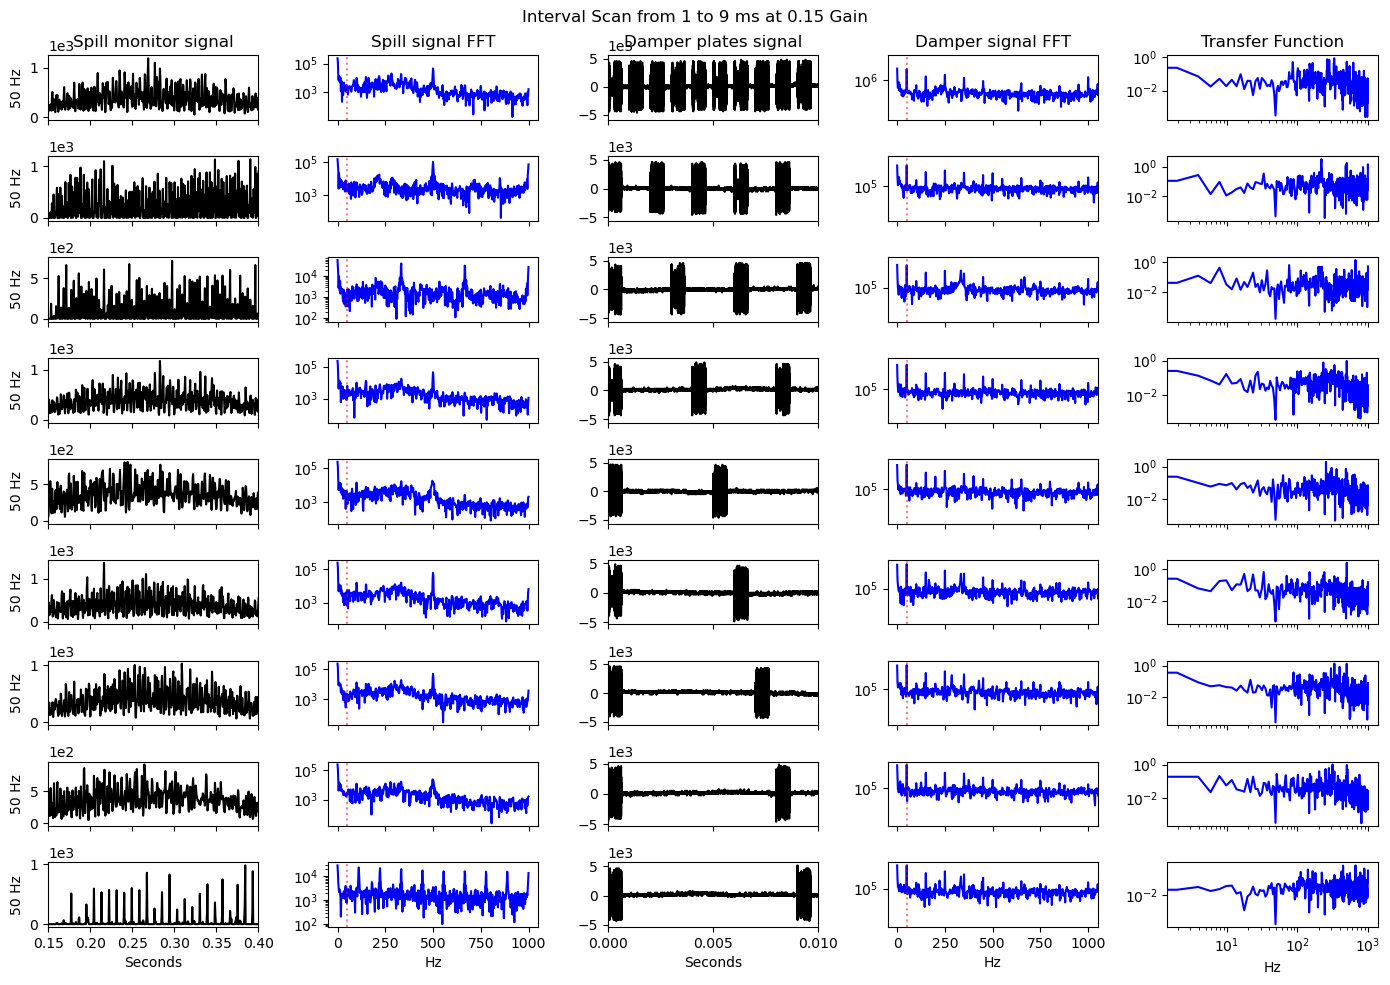

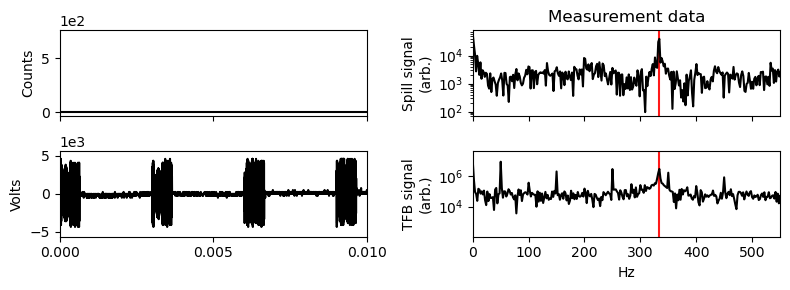

In [36]:
tf_df_15 = generate_transfer_function_plot('../results/2022-11-23T15:16:55')

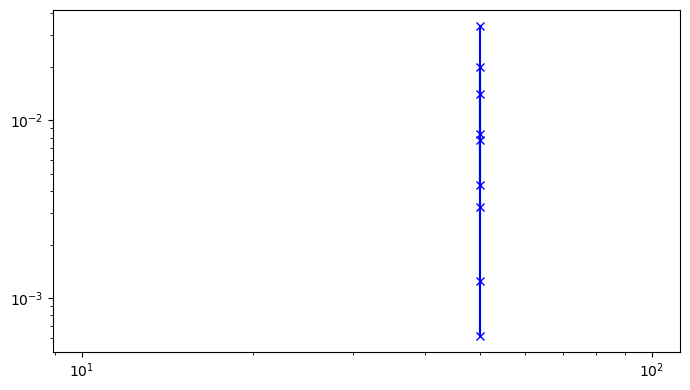

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

#ax.plot(tf_df['Frequency'], tf_df['Spill'], 'r')
#ax.plot(tf_df['Frequency'], tf_df['Damper'], 'g')
ax.plot(tf_df_15['Frequency'], tf_df_15['Spill']/tf_df_15['Damper'], 'bx-')
ax.set_xscale('log')
ax.set_yscale('log')

# 0.1 Gain

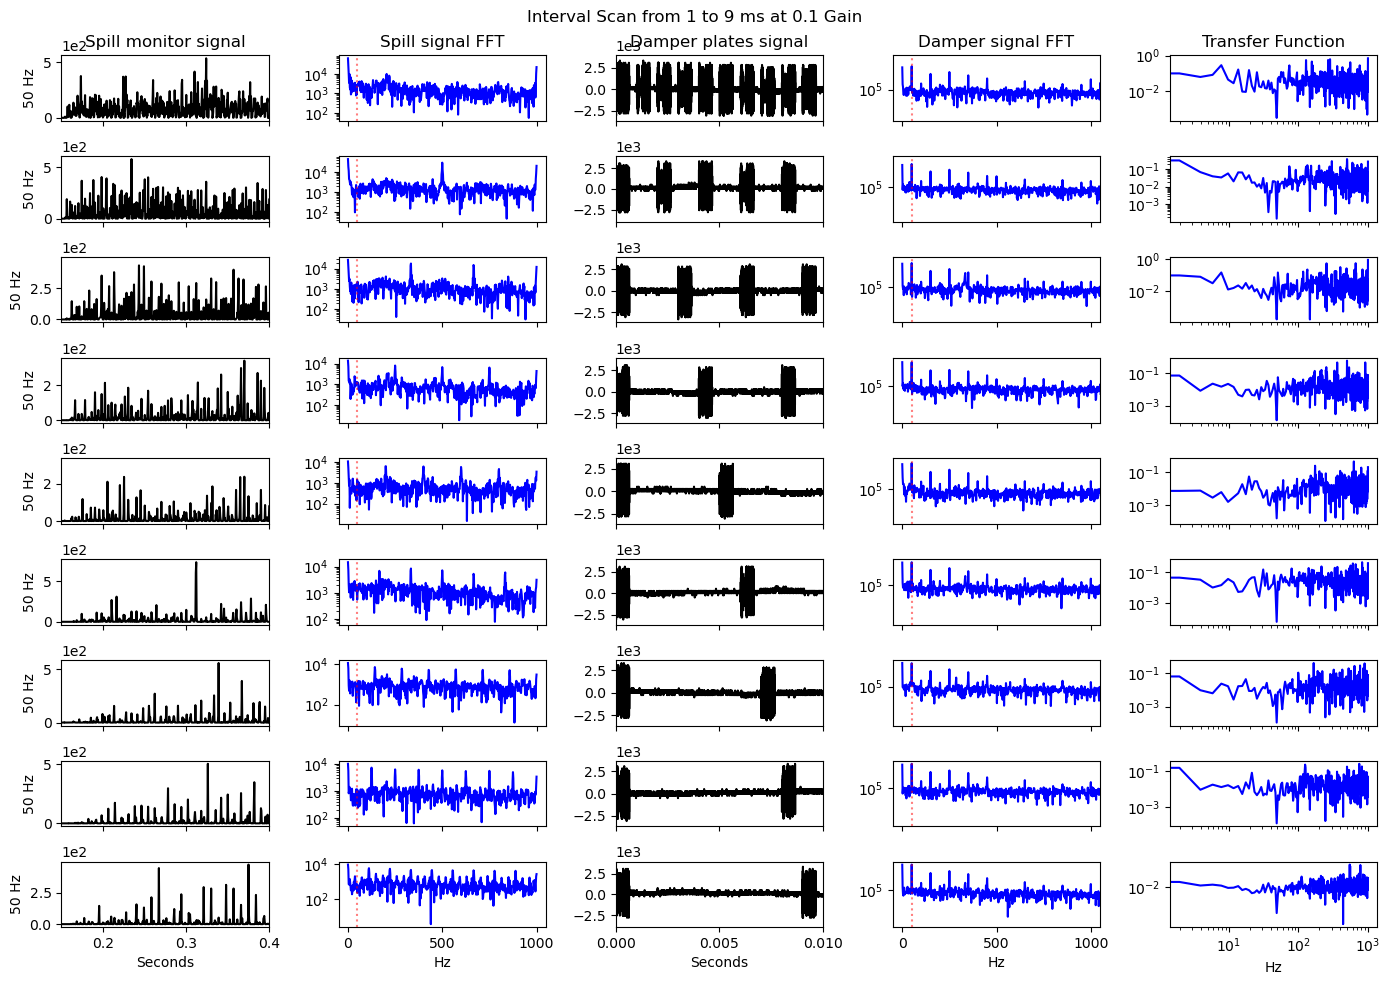

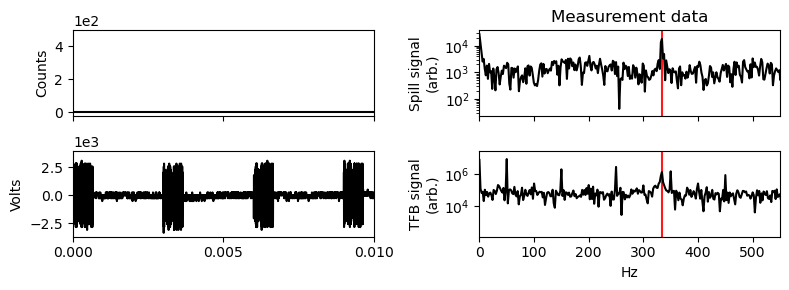

In [38]:
tf_df_1 = generate_transfer_function_plot('../results/2022-11-23T14:44:26')

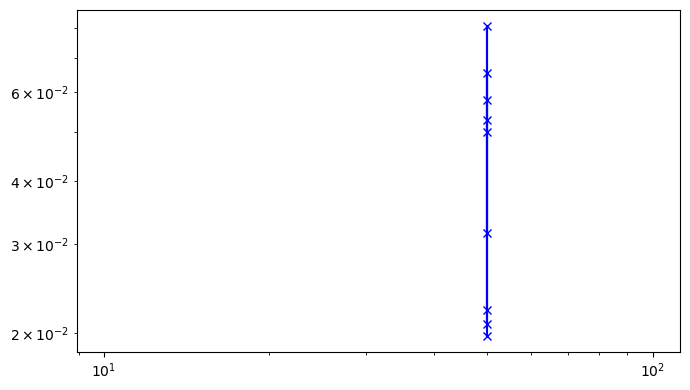

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

#ax.plot(tf_df['Frequency'], tf_df['Spill'], 'r')
#ax.plot(tf_df['Frequency'], tf_df['Damper'], 'g')
ax.plot(tf_df_1['Frequency'], tf_df_1['Spill']/tf_df_1['Damper'], 'bx-')
ax.set_xscale('log')
ax.set_yscale('log')

# 0.075 Gain

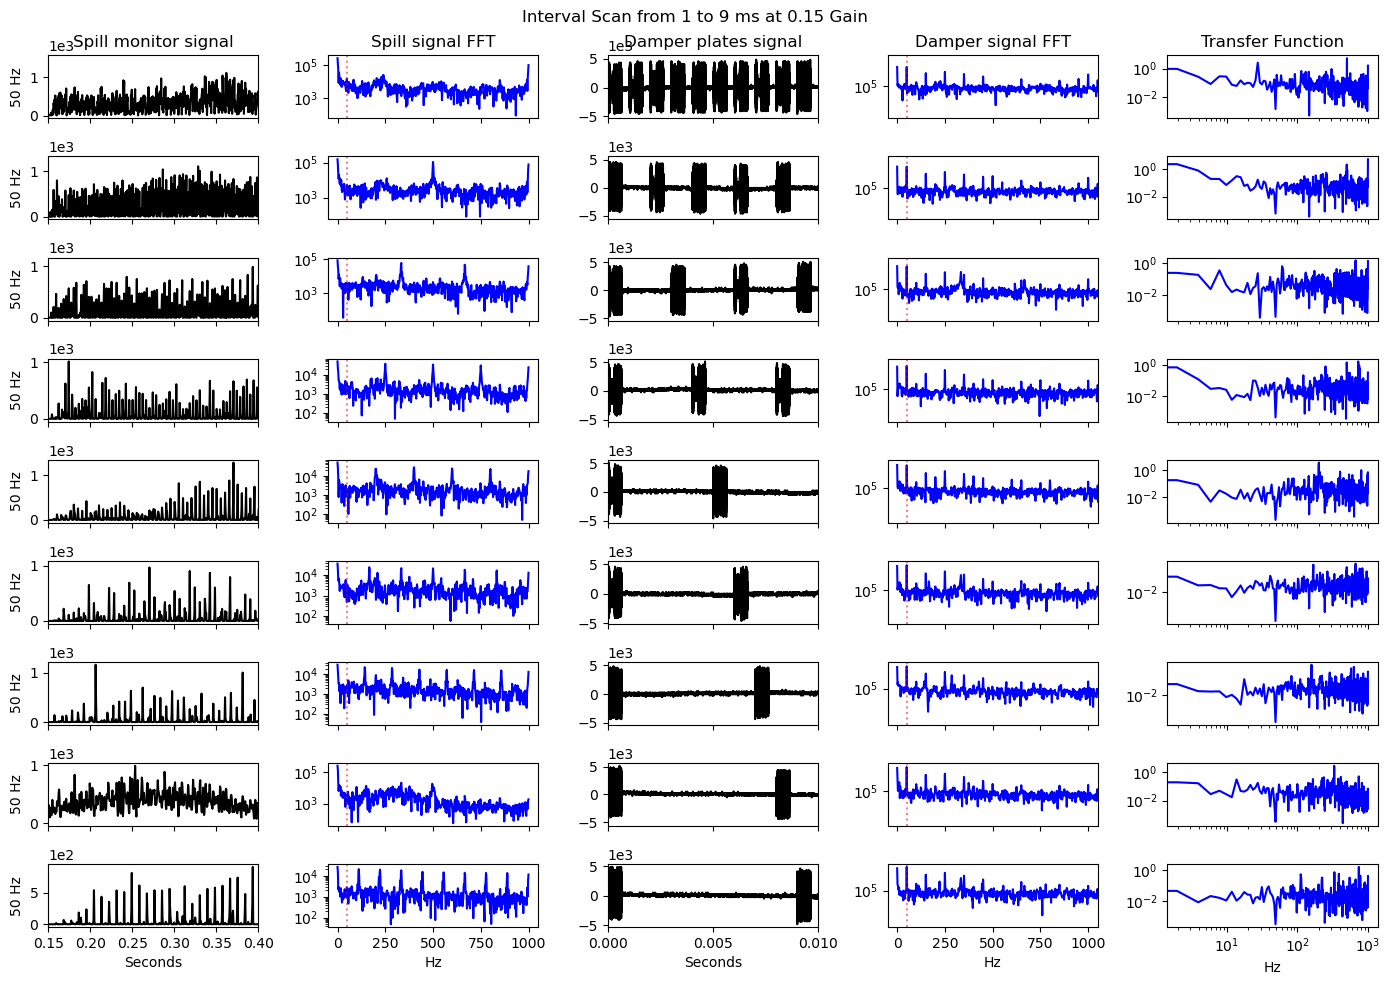

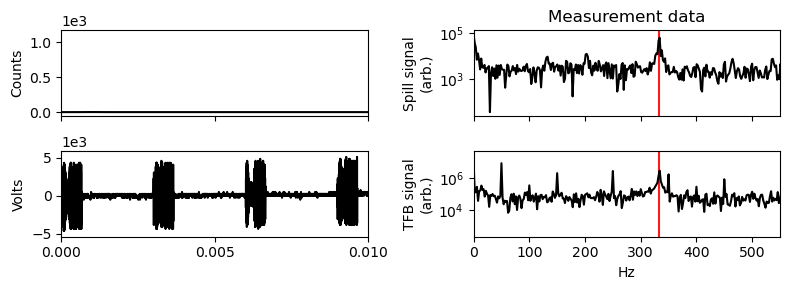

In [40]:
tf_df_75 = generate_transfer_function_plot('../results/2022-11-23T15:08:29')

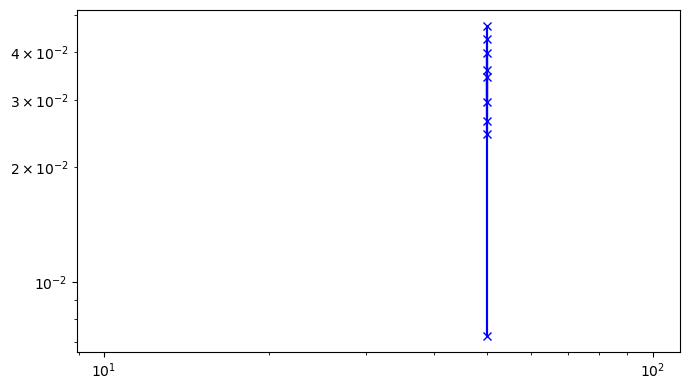

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

#ax.plot(tf_df['Frequency'], tf_df['Spill'], 'r')
#ax.plot(tf_df['Frequency'], tf_df['Damper'], 'g')
ax.plot(tf_df_75['Frequency'], tf_df_75['Spill']/tf_df_75['Damper'], 'bx-')
ax.set_xscale('log')
ax.set_yscale('log')

# 0.05 Gain

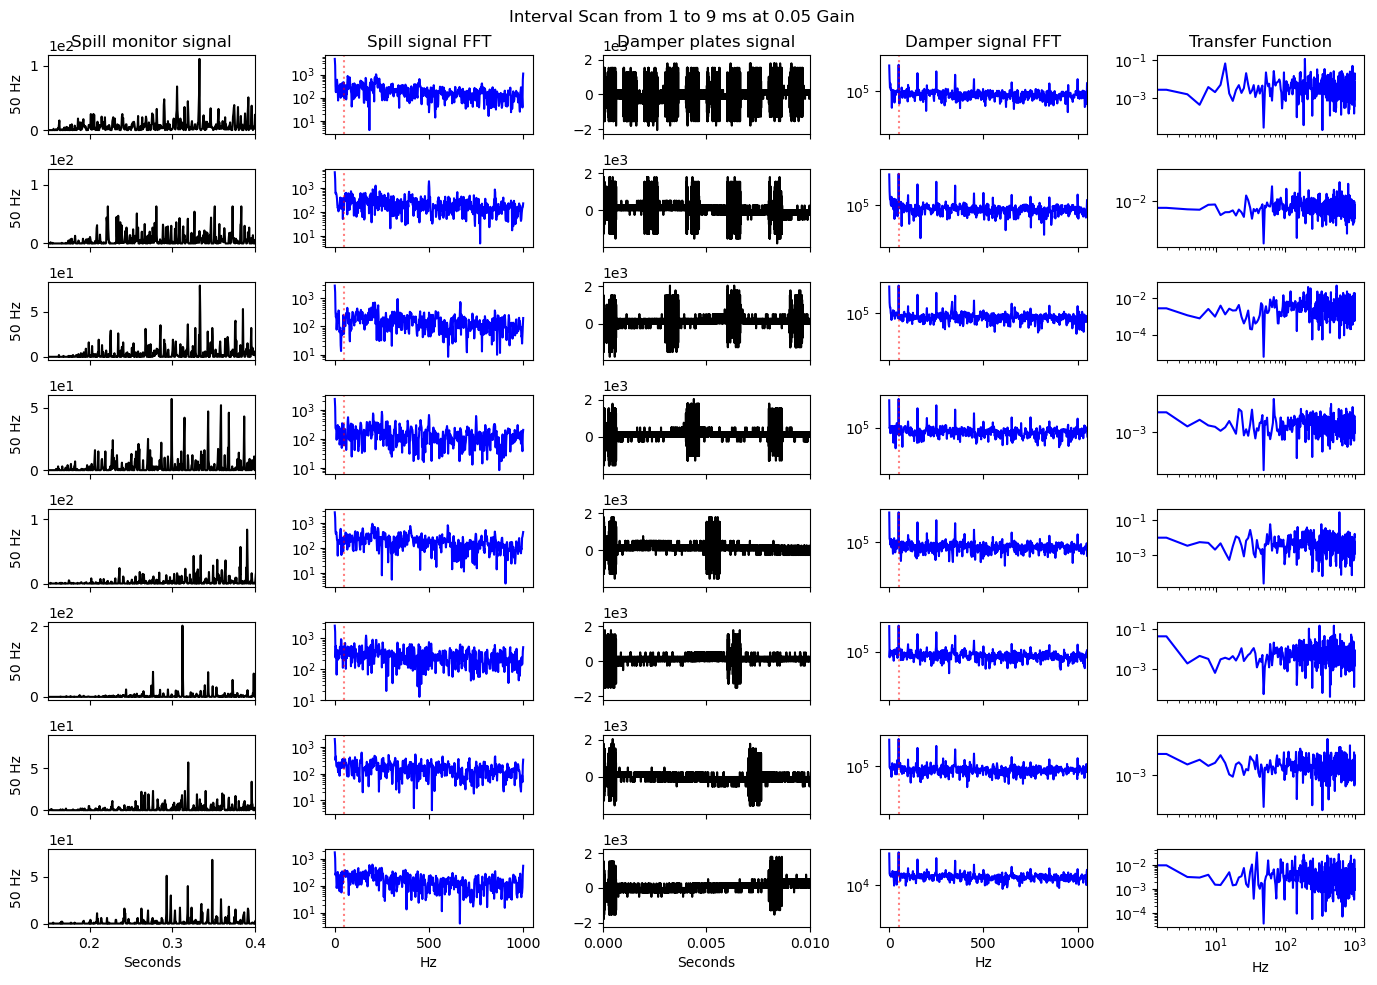

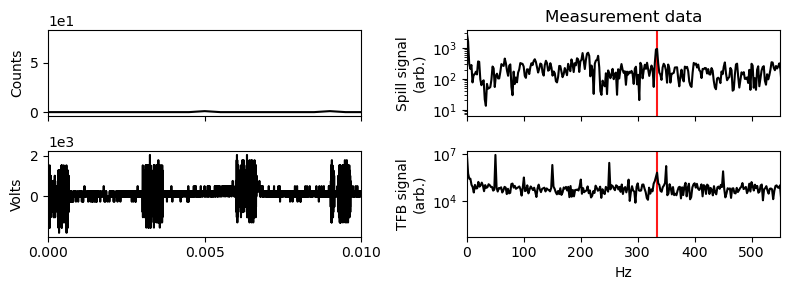

In [42]:
tf_df_5 = generate_transfer_function_plot('../results/2022-11-23T14:34:55')

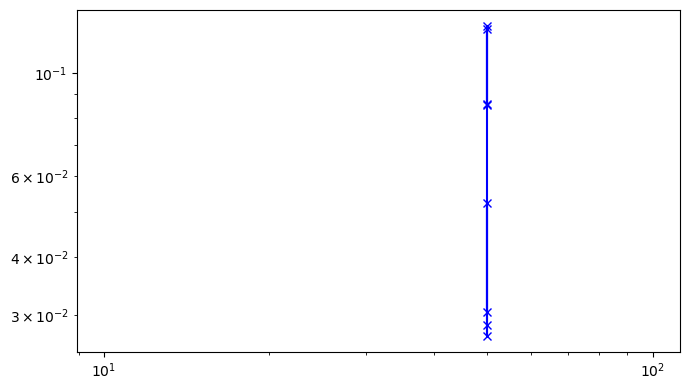

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

# ax.plot(tf_df['Frequency'], tf_df['Spill'], 'r')
# ax.plot(tf_df['Frequency'], tf_df['Damper'], 'g')
ax.plot(tf_df_5['Frequency'], tf_df_5['Spill']/tf_df_5['Damper'], 'bx-')
ax.set_xscale('log')
ax.set_yscale('log')

Text(0.5, 1.0, '50 Hz Ripple')

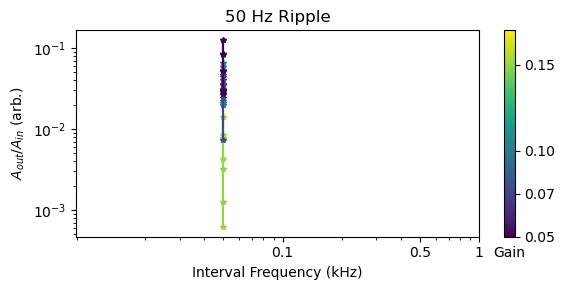

In [44]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
cmap = plt.get_cmap('viridis')
# ax.plot(tf_df['Frequency'], tf_df['Spill'], 'r')
# ax.plot(tf_df['Frequency'], tf_df['Damper'], 'g')
norm = mpl.colors.Normalize(vmin=0.05, vmax=0.17)
ax.plot(tf_df_15['Frequency'], tf_df_15['Spill']/tf_df_15['Damper'], '*-', markersize=4, label='Gain: 0.15', c=cmap(norm(0.15)))
ax.plot(tf_df_1['Frequency'], tf_df_1['Spill']/tf_df_1['Damper'], '*-', markersize=4, label='Gain: 0.1', c=cmap(norm(0.1)))
ax.plot(tf_df_75['Frequency'], tf_df_75['Spill']/tf_df_75['Damper'], '*-', markersize=4, label='Gain: 0.075', c=cmap(norm(0.075)))
ax.plot(tf_df_5['Frequency'], tf_df_5['Spill']/tf_df_5['Damper'], '*-', markersize=4, label='Gain: 0.05', c=cmap(norm(0.05)))


ax.set_xscale('log')
ax.set_yscale('log')
#ax.legend(loc='upper right', ncol=2)
ax.set_xticks([100, 500, 1000])
ax.set_xticklabels(['0.1', '0.5', '1'])
ax.set_xlabel('Interval Frequency (kHz)')
ax.set_ylabel(r'$A_{out}/A_{in}$ (arb.)')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm,
             ticks = [0.05, 0.075, 0.1, 0.15],
             format = '%.2f',
             )
cb.ax.set_title('Gain', y=-0.14, size='medium')

ax.set_title(f'{RIPPLE} Hz Ripple')

# Test